In [ ]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [ ]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz


In [ ]:
from tools.misc_tools import create_Lorenz_data, create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data, plot_latent_states, readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.LSTM_SingleStep_v1 import RNN_LSTM
from tools.LSTM_AR_v1 import AR_RNN_LSTM

In [ ]:
# behaviour = 'initialiseAndTrainFromScratch'
behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [ ]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [ ]:
tf.test.gpu_device_name()
tf.__version__

'2.8.2'

# Lorenz System

In [ ]:
# setting up params

from numpy import *

### Simutlation paramaters
if behaviour == 'initialiseAndTrainFromScratch':
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_005'
    dir_sim_data = dir_name_rnn
    dir_rnn_data = dir_name_rnn
else:
    dir_name_AR_rnn = os.getcwd()+'/saved_AR_rnn/AR_rnn_000'
    # dir_name_rnn = dir_name_ae_rnn + '{ds}initial_net{ds}RNN'.format(ds=dir_sep)
    # dir_name_ae = dir_name_ae_rnn + '{ds}initial_net{ds}AE'.format(ds=dir_sep)
    dir_sim_data = dir_name_AR_rnn
    dir_rnn_data = dir_name_AR_rnn

with open(dir_sim_data + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))


dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]

rho_arr = params_dict['rho_arr']
sigma_arr = params_dict['sigma_arr']
beta_arr = params_dict['beta_arr']

x0 = params_dict['x0']
y0 = params_dict['y0']
z0 = params_dict['z0']

t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']

normalize_flag = params_dict['normalize_flag']


### RNN paramaters
with open(dir_rnn_data + '/RNN_specific_data.txt') as f:
    lines = f.readlines()

params_rnn_dict = eval(''.join(lines))

dt_rnn = params_rnn_dict['dt_rnn']
# T_sample_input = params_rnn_dict['T_sample_input']
T_sample_output = params_rnn_dict['T_sample_output']
# T_offset = params_rnn_dict['T_offset']
return_params_arr = params_rnn_dict['return_params_arr']


# input and offset times for training the autoregressive model
T_sample_input = dt_rnn
T_offset = T_sample_input

In [ ]:
res_dict = create_Lorenz_data(
    T, t0, delta_t,
    rho_arr, sigma_arr, beta_arr,
    x0, y0, z0, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [ ]:
n = len(boundary_idx_arr)

# Autoencoder

In [ ]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

load_file = dir_name_ae + '{ds}final_net{ds}'.format(ds=dir_sep)

wt_file = load_file + 'final_net_ae_weights.h5'
load_file += 'final_net_class_dict.txt'

In [ ]:
ae_net = Autoencoder(6, load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [ ]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

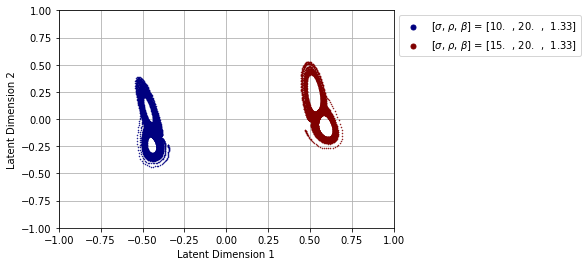

In [ ]:
fig, ax = plot_latent_states(
    boundary_idx_arr=boundary_idx_arr,
    latent_states_all=latent_states_all,
    all_data=all_data,
    xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='jet')

# LSTM

In [ ]:
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_load_file_path = dir_name_rnn+'{ds}final_net{ds}'.format(ds=dir_sep)
elif behaviour == 'loadCheckpointAndContinueTraining':
    rnn_load_file_path = dir_name_AR_rnn + '{ds}initial_net{ds}RNN{ds}'.format(ds=dir_sep)
elif behaviour == 'loadFinalNetAndPlot':
    rnn_load_file_path = dir_name_AR_rnn + '{ds}final_net{ds}RNN{ds}'.format(ds=dir_sep)

rnn_weights_path = rnn_load_file_path + 'final_net_lstm_weights.h5'
rnn_load_file_path += 'final_net_class_dict.txt'

In [ ]:
rnn_net = RNN_LSTM(load_file=rnn_load_file_path)
temp = rnn_net.predict(tf.ones(shape=[1, 1, rnn_net.data_dim]))
rnn_net.load_weights_from_file(file_name=rnn_weights_path)
# rnn_net.load_weights_from_file(file_name=rnn_weights_path[0:-3])

# AutoRegressive Model

In [ ]:
if return_params_arr != False:
    params = params_arr
else:
    params = None

data_rnn_input, data_rnn_output, org_data_idx_arr_input, org_data_idx_arr_output, num_samples = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    N,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True)

In [ ]:
# saving training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_dict = {
        'eta_begin':0.00005,
        'eta_high':0.0001,
        'eta_low':0.00001
    }
    epochs = 1000
    patience = 50  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-5  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
else:
    with open(dir_name_AR_rnn+'/training_specific_params.txt', 'r') as f:
        lines = f.readlines()

    training_param_dict = eval(''.join(lines))

    learning_rate_dict = training_param_dict['learning_rate_dict']
    epochs = training_param_dict['epochs']
    patience = training_param_dict['patience']
    min_delta = training_param_dict['min_delta']
    prng_seed = training_param_dict['prng_seed']
    train_split = training_param_dict['train_split']
    val_split = training_param_dict['val_split']
    batch_size = training_param_dict['batch_size']
    test_split = 1 - train_split - val_split

    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)


In [ ]:
idx = np.arange(num_samples)
# np.random.shuffle(idx)
boundary = int(np.round(
    (1-test_split) * num_samples
))

# defining shapes
training_input_shape = [boundary*len(boundary_idx_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [boundary*len(boundary_idx_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [(num_samples-boundary)*len(boundary_idx_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [(num_samples-boundary)*len(boundary_idx_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

for i in range(len(boundary_idx_arr)):
    np.random.shuffle(idx)

    training_data_rnn_input[i*boundary:(i+1)*boundary] = data_rnn_input[i*num_samples + idx[0:boundary]]
    training_data_rnn_output[i*boundary:(i+1)*boundary] = data_rnn_output[i*num_samples + idx[0:boundary]]

    testing_data_rnn_input[i*(num_samples-boundary):(i+1)*(num_samples-boundary)] = data_rnn_input[i*num_samples + idx[boundary:]]
    testing_data_rnn_output[i*(num_samples-boundary):(i+1)*(num_samples-boundary)] = data_rnn_output[i*num_samples + idx[boundary:]]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [ ]:
### defining the autoregressive RNN
AR_rnn_net = AR_RNN_LSTM(
    T_input=T_sample_input,
    T_output=T_sample_output,
    load_file=rnn_load_file_path
)

In [ ]:
if behaviour == 'loadCheckpointAndContinueTraining':
    temp = AR_rnn_net(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), AR_rnn_net.data_dim]))
    AR_rnn_net.load_weights(dir_name_AR_rnn+'{ds}checkpoints{ds}checkpoint'.format(ds=dir_sep))

In [ ]:
### saving some data
if behaviour == 'initialiseAndTrainFromScratch':
    dir_name_AR_rnn = os.getcwd() + dir_sep + 'saved_AR_rnn'
    if not os.path.isdir(dir_name_AR_rnn):
        os.makedirs(dir_name_AR_rnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_AR_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_AR_rnn = dir_name_AR_rnn + dir_sep + dir_check
    print('AR-RNN save directory : ' + dir_name_AR_rnn)
    os.makedirs(dir_name_AR_rnn)
    os.makedirs(dir_name_AR_rnn+dir_sep+'plots')
    dir_name_data = {
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
    }

    with open(dir_name_AR_rnn+dir_sep+'ae_rnn_dirs.txt', 'w') as f:
        f.write(str(dir_name_data))

    with open(dir_name_AR_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(params_dict))

    with open(dir_name_AR_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(params_rnn_dict))

    training_specific_params = {
        'learning_rate_dict':learning_rate_dict,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size
    }

    with open(dir_name_AR_rnn+'/training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))


    ### saving the inital RNN
    save_dir=dir_name_AR_rnn+dir_sep+'initial_net'
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    dir_rnn = save_dir + dir_sep + 'RNN'
    if not os.path.isdir(dir_rnn):
        os.makedirs(dir_rnn)
    save_file_rnn = dir_rnn + dir_sep + 'final_net'
    rnn_net.save_everything(save_file_rnn)

In [ ]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs)*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs)*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_AR_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=[0])
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_AR_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [ ]:
# compiling the network
AR_rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dict['eta_begin']),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_AR_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=5  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=5)
    
    # sigmoid annealing lr schedule
    lrschedule_cb = sigmoidWarmupAndDecayLRSchedule(
        eta_begin=learning_rate_dict['eta_begin'],
        eta_high=learning_rate_dict['eta_high'],
        eta_low=learning_rate_dict['eta_low'],
        warmup=20,
        expected_epochs=200,
        g_star=0.999,
        f_star=0.001
    )

    # training the network
    savelosses_cb.update_offset(epochs - num_epochs_left)
    
    history = AR_rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
        epochs=num_epochs_left,
        batch_size=batch_size,
        validation_split=val_split/train_split,
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb, lrschedule_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])

Epoch 1/450
222/222 [==============================] - 116s 243ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 2/450
222/222 [==============================] - 48s 217ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 3/450
222/222 [==============================] - 48s 217ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 4/450
222/222 [==============================] - 48s 217ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 5/450
222/222 [==============================] - ETA: 0s - loss: 0.0128 - tot_time: 0h 5m 8.6s

Epoch 5: val_loss improved from inf to 0.01278, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/saved_AR_rnn/AR_rnn_000/checkpoints/checkpoint
 - saving loss histories at /content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/saved_AR_rnn/AR_rnn_000/checkpoints/LossHistoriesCheckpoint
222/222 [==============================] - 48s 218ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 6/450
222/222 [==============================] - 48s 218ms/step - loss: 0.0128

In [ ]:
training_data_rnn_output.shape

(16202, 100, 2)

In [ ]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = AR_rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_AR_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))

    AR_rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

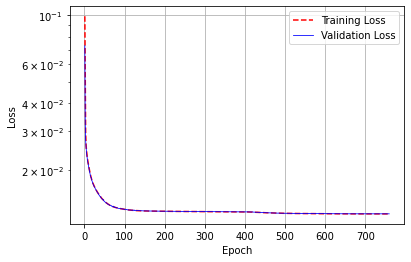

In [29]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=None
)

plt.savefig(dir_name_AR_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 2286


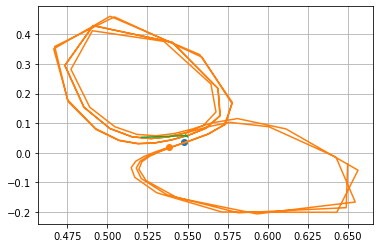

In [84]:
data_type = 'training'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 10
print('data_idx : {}'.format(data_idx))


plt.plot(data_in[data_idx, :, 0], data_in[data_idx, :, 1], 'o')
plt.plot(data_out[data_idx, 0, 0], data_out[data_idx, 0, 1], 'o')
plt.plot(data_out[data_idx, :, 0], data_out[data_idx, :, 1], 'C1')

prediction = AR_rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
plt.plot(prediction[0, :, 0], prediction[0, :, 1])

plt.grid(True)
plt.show()

In [61]:
training_data_rnn_output[5000:5064].shape

(64, 100, 2)